# Chapter 3: Generative Adversarial Networks (GANs)




***
“Adversarial training (also called GAN for Generative Adversarial Networks), and the variations that are now being proposed, is the most interesting idea in the last 10 years in ML, in my opinion.”


-- Yann LeCun 
***


Most of the generative models in this book belong to a framework called Generative Adversarial Networks (GANs). The framework was first proposed by Ian Goodfellow and his coauthors in 2014. GANs involve two models: a generative model G to capture the data distribution and a discriminative model D to estimate the probability that a sample came from the training data (real) rather than from G (fake). In equilibrium, G produces samples that are indistinguishable from real samples while D assigns a probability of 50% to any sample (real or fake) that it's real. The work has since spawned many interesting research in the area and GANs are one of the hottest topics in machine learning (ML) and AI these days. 

This chapter introduces you to the basic idea behind GANs and you'll learn to use the framework to generate data samples that form an inverted-U shape. At the end of this chapter, you'll be able to generate data to mimic any shape: sine, cosine, quadratic, and so on. 

# 1. A Summary of Generative Adversarial Networks (GANs)

Generative Adversarial Networks (GANs) consist of two neural networks: a generative neural network G and a discriminative neural network D. The generator G tries to create samples that is indistinguishable from those from a training dataset. The material the generator is trying to generate can be anything: text, music, images, figures, or patterns, as long as there is a training dataset of such material that the generator can learn from. In this chapter, you'll learn how to teach the generator to create a figure of a certain shape. The discriminator D will be presented with either a real sample from the training dataset, or a fake that was generated by G. The discriminator tries to estimate the probability that the sample came from the training data rather than from the generator. 

In the training stage, the generator is trying to maximize the probability that the sample it generates passes the discriminator as real. The objective of the discriminator is to maximize the accuracy of its predictions: to identify a fake sample as fake and a real sample as real. In equilibrium, G produces samples that are indistinguishable from real samples while D assigns a probability of 50% to any sample (real or fake) that it's real. 

Once the training is over, we discard the discriminator and keep the generator. We then use the generator to create samples that are indistinguishable from observations in the training dataset. 

# 2.  GANs to Generate Shapes
In this chapter, you'll learn exactly how GANs work by trying to generate a dataset with an inverted-U shape. The dataset contains two dimensional elements $(x,y)$, where $x$ is uniformly distributed in the interval $[-5, 5]$ and $y=10-x^2$. We first generate the training dataset so that the generator can learn from it. 

## 2.1. An Inverted-U Shape
First, we create 2048 values of $x$ between -5 and 5, using the *torch.rand()* method, like so:

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch

torch.manual_seed(0)
# x is from -5 to 5
train_data = torch.zeros((2048, 2))
train_data[:,0]=10*(torch.rand(2048)-0.5)

The *manual_seed()* method in PyTorch fixes the random state so that all results are reproducible. We first create a PyTorch tensor, *train_data*, with 2048 rows and two columns. The values of *x* are placed in the first column. The *rand()* method in PyTorch generates random values between 0.0 and 1.0. By first subtracting 0.5 from the random value and then multiplying the difference by 10, the resulting value of $x$ is between -5 and 5. 

We then fill the second column of *train_data* with values of $y=10-x^2$, like so:

In [2]:
# y=10-x^2
train_data[:,1]=10-train_data[:,0]**2

We plot the relation between $x$ and $y$ by using the *matplotlib* library:

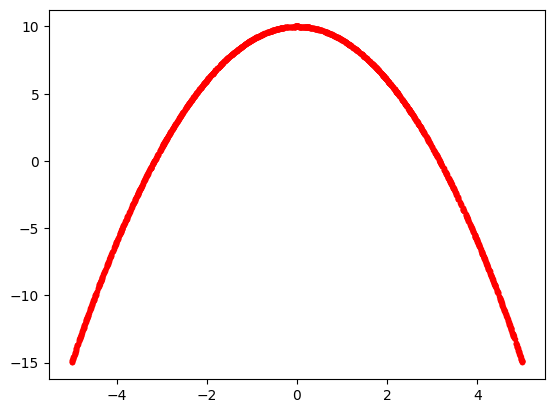

In [3]:
import matplotlib.pyplot as plt

plt.plot(train_data[:,0],train_data[:,1],".",c="r")
plt.show()

The plot shows an inverted-U shape between $x$ and $y$. 

## 2.2. Prepare the Training Dataset
We use the *DataLoader()* class in PyTorch to wrap an iterable around the training dataset so that we can easily access the samples during training, like so:

In [4]:
from torch.utils.data import DataLoader

batch_size=64
train_loader=DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True)

Make sure you select the total number of observations and the batch size so that all batches have the same size. We choose 2048 observations with a batch size of 64. As a result, we have 2048/64=32 batches. The *shuffle=True* argument in *DataLoader()* shuffles the observations randomly before dividing them into batches. 

You can access a batch of data by using the *next()* and *iter()* methods, like so:

In [5]:
batch0=next(iter(train_loader))
print(batch0)

tensor([[  3.8738,  -5.0061],
        [ -3.1898,  -0.1747],
        [ -0.4007,   9.8395],
        [  3.9525,  -5.6223],
        [ -4.5009, -10.2578],
        [ -0.5481,   9.6996],
        [ -3.4662,  -2.0144],
        [  4.7367, -12.4365],
        [ -4.1755,  -7.4345],
        [  0.6398,   9.5907],
        [  4.5831, -11.0045],
        [ -0.5490,   9.6986],
        [  3.3116,  -0.9667],
        [ -2.3607,   4.4272],
        [  0.1878,   9.9647],
        [  0.3278,   9.8925],
        [  3.5149,  -2.3547],
        [  3.4085,  -1.6177],
        [ -4.0577,  -6.4652],
        [ -0.5361,   9.7126],
        [ -4.8367, -13.3932],
        [  1.8641,   6.5252],
        [  4.9714, -14.7146],
        [  1.9142,   6.3358],
        [  3.2627,  -0.6453],
        [  1.9202,   6.3127],
        [  0.1390,   9.9807],
        [  2.5077,   3.7117],
        [ -0.9953,   9.0095],
        [ -1.5283,   7.6642],
        [  0.7693,   9.4082],
        [ -2.6748,   2.8452],
        [  0.2230,   9.9503],
        [ 

The picture shows 32 clothes items such as coats, pullovers, sandals and so on. 

Next, we'll create batches of data for training. 

# 3. Create Generative Adversarial Networks (GANs)
We'll create two neural networks in this section: one for the discriminator D and one for the generator G. 

## 3.1. The Discriminator Network
The discriminator D is a binary classifier, which is very similar to the binary classifier for clothes items we discussed in Chapter 2. Here the discriminator's job is to classify the samples into either real or fake. 

We use PyTorch to create the following discriminator neural network D, like so:

In [6]:
import torch.nn as nn

# determine the device automatically
device="cuda" if torch.cuda.is_available() else "cpu"
# the discriminator D is a binary classifier
D=nn.Sequential(
    nn.Linear(2,256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64,1),
    nn.Sigmoid()).to(device)

Make sure that in the first layer, the input shape is 2 because our sample has two values: $x$ and $y$. Also make sure that the output layer has just one neuron in it: the output of the discriminator D is a single value. We use the Sigmoid activation function to squeeze the output to the range [0, 1] so it can be interpreted as the probability that the sample is real. With complementary probability 1-p, the object is fake. 

The hidden layers have 256, 128, and 64 neurons in them, respectively. There is nothing magic about thoese numbers, and you can easily change those numbers and have similar results. 

## 3.2. The Generator Network
The generator G's job is to create a pair of numbers $(\tilde{x},\tilde{y})$ so that it can pass the screening of the discriminator D. That is, G is trying to create a pair of numbers to maximize the probability that D thinks the numbers are from the training dataset (i.e., with a relation $\tilde{y}=10-\tilde{x}^2$).

We create the following neural network to respresent the generator G:

In [7]:
G=nn.Sequential(
    nn.Linear(2,16),
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU(),
    nn.Linear(32,2)).to(device)

We'll feed random data from a two-dimensional latent space, $(z_1, z_2)$, to the generator. The generator then generates a pair of values $(\tilde{x},\tilde{y})$ based on the input from the latent space. Here we use a two-dimensional latent space, and we have some flexibility in choosing the dimension of the latent space. Changing the dimension to other numbers such as five or ten wouldn't affect our results.  

One question often asked is the meaning of the latent space. There is no obvious answer to the question. The latent space has meanings only when it's applied to the generative model. One can interpolate between points in the latent space and the generative model to affect the output, which is out of the scope of the book. 

## 3.3. Optimizers and Loss Functions

The loss function is binary cross-entropy loss. The discriminator D is trying to maximize the accuracy of the binary classification: identify a real sample as real and a fake sample as fake. The generator, on the other hand, is trying to minimize the probability that the fake sample is being identified as fake. 

We'll use the Adam optimizer for both the discriminator and the generator:

In [8]:
loss_fn=nn.BCELoss()
lr=0.001
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

# 4. Train and Use Generative Adversarial Networks (GANs)
Now that we have the training data and two networks, we'll train the model. After that, we'll discard the discriminator and use the generator to generate data points that form the inverted-U shape. 

## 4.1. Train the Model
We first create labels of zeros and ones as follows:

In [9]:
real_labels=torch.ones((batch_size,1)).to(device)
fake_labels=torch.zeros((batch_size,1)).to(device)

The real labels are all ones, while the fake labels are all zeros. We'll compare these labels with the predictions from the discriminator to train both the discriminator and the generator. 

We define a *train_epoch()* function below, which train the model by using all observations in the training dataset once: 

In [10]:
def train_epoch(epoch):
    gloss=dloss=0
    for n, real_samples in enumerate(train_loader):
        real_samples=real_samples.to(device)
        # Train D on real samples
        D.zero_grad()
        out_D=D(real_samples)
        loss_D=loss_fn(out_D,real_labels)
        loss_D.backward()
        optimD.step()
        dloss+=loss_D
        # Train D on fake samples
        # obtain inputs from the latent space
        noise=torch.randn((batch_size,2)).to(device)
        # feed the input to the generator 
        fake_samples=G(noise)        
        D.zero_grad()
        out_D=D(fake_samples)
        loss_D=loss_fn(out_D,fake_labels)
        loss_D.backward()
        optimD.step()
        dloss+=loss_D
        # Train G
        noise=torch.randn((batch_size,2)).to(device)
        G.zero_grad()
        fake_samples=G(noise)
        out_G=D(fake_samples)
        # G maximizes the prob that D thinks the samples are real
        loss_G=loss_fn(out_G,real_labels)
        loss_G.backward()
        optimG.step() 
        gloss+=loss_G
    # look at the generated sample after every 50 epochs   
    if epoch==0 or (epoch+1)%100==0:
        # print the loss in the epoch
        print(f"at epoch {epoch},\
        G loss: {gloss.item()}, D loss {dloss.item()}")        
        plt.plot(fake_samples.detach().cpu().numpy()[:,0],
         fake_samples.detach().cpu().numpy()[:,1],".",c="g")
        plt.plot(train_data[:,0],train_data[:,1],".",c="r")
        plt.title(f"epoch {epoch+1}")
        plt.xlim(-6,6)
        plt.ylim(-16,11)
        plt.savefig(f"p{epoch+1}.jpg")
        plt.show()

We iterate through all batches in the training dataset. For each batch of data, we first train the discriminator using the real samples. After that, the generator creates a batch of fake samples and we use them to train the discriminator D again. Finally, we let the generator create a batch of fake samples again, but we use them to train the generator instead.

Next, we train the model for 300 epochs, like so:

at epoch 0,        G loss: 40.46297836303711, D loss 18.244586944580078


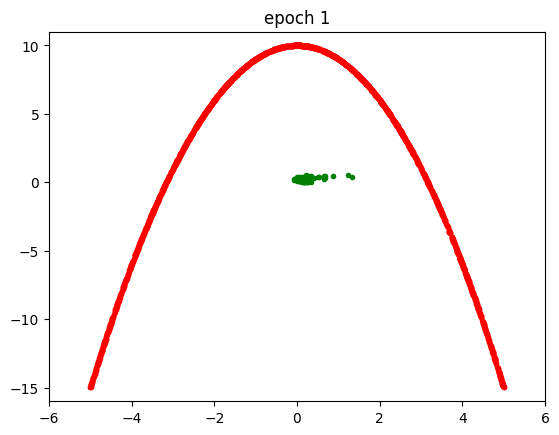

at epoch 99,        G loss: 23.9744930267334, D loss 43.772647857666016


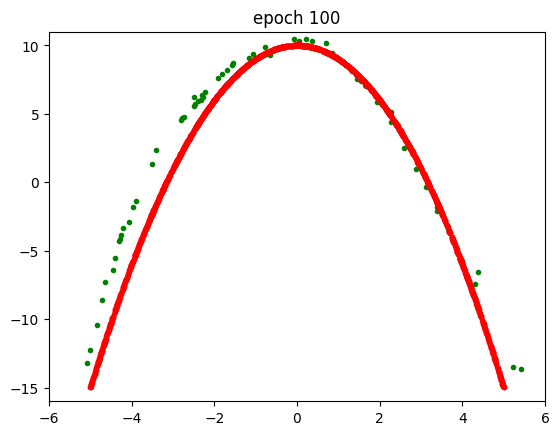

at epoch 199,        G loss: 30.484743118286133, D loss 41.44502639770508


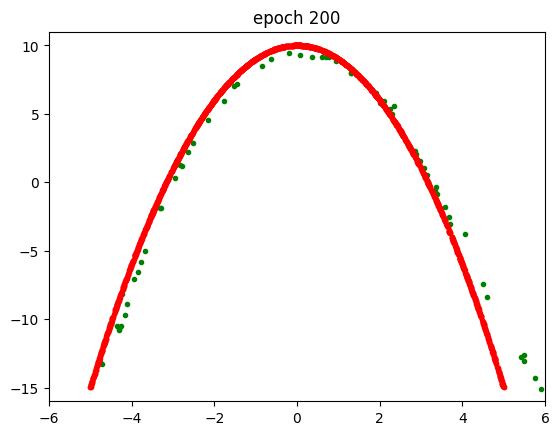

at epoch 299,        G loss: 33.277034759521484, D loss 40.210819244384766


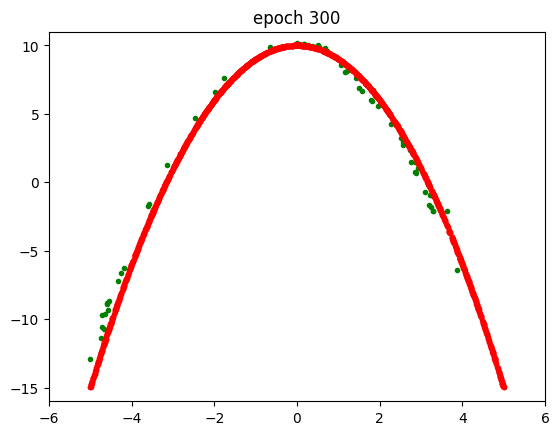

In [11]:
for epoch in range(300):
    train_epoch(epoch)

The above results show that after just one epoch of training, the generated data (in green color) are clustered around the point $(0,0)$ and don't form any shape. After 100 epochs of training, the data points start to form an inverted-U shape, even though many points are far away from the red curve, which is constructed by ground truth. After 200 epochs, the green dots are closely aligned with the red curve. After 300 epochs, all the green dots are close to the red curve. This shows that the model works well: the generator is able to generate data points to form an inverted-U shape. 

## 4.2. Use the Trained Model
We'll discard the discriminator and save the trained generator on the local folder, as follows:

In [12]:
# Export to TorchScript
scripted = torch.jit.script(G) 
# Save the model
os.makedirs("files/ch03", exist_ok=True)
scripted.save('files/ch03/gen.pt') 

We have now saved the generator to the local folder. To use the generator, we don't even need to define the model. We simply load up the model and use it to generate data points as follows: 

In [13]:
new_G=torch.jit.load('files/ch03/gen.pt',map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=Linear)
)

The generator is now reloaded. We can use it to generate 200 pairs of data points as follows:

In [14]:
# obtain inputs from the latent space
noise=torch.randn((200,2)).to(device)
# feed the input to the generator 
new_data=new_G(noise) 

Since we need to generate 200 pairs of data, we first generate 200 pairs of values from the latent space. We then feed them to the new generator to produce the fake data. We can plot the generated data as follows:

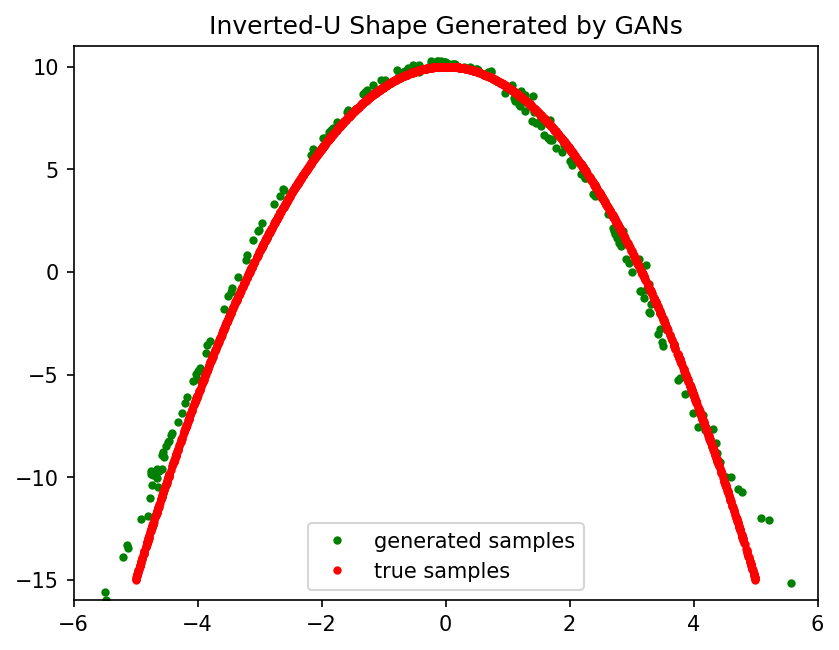

In [15]:
fig=plt.figure(dpi=150)
plt.plot(new_data.detach().cpu().numpy()[:,0],
  new_data.detach().cpu().numpy()[:,1],".",c="g",
        label="generated samples")
plt.plot(train_data[:,0],train_data[:,1],".",c="r",
         label="true samples")
plt.title("Inverted-U Shape Generated by GANs")
plt.xlim(-6,6)
plt.ylim(-16,11)
plt.legend()
plt.show()

The generated dataset matches the inverted-U shape fair well. 

You can easily change the code so the generated data match other shapes such as sine, cosine, U-shape, and so on. And I leave those as exercises for you.